In this notebook, we search for ground states of the Transverse Field Ising (TFI) model on a finite honeycomb lattice using imaginary time TEBD algorithm. We start by showing that increasing the bond dimension yields a lower ground state energy. We then compute imaginary time TEBD for different time steps $\Delta\tau$, observing that there exists an optimal time step at which the computed ground state energy is lowest.

# Ground state search for different values of $D_\text{max}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../../")
from src.isoTPS.honeycomb import isoTPS
from src.models import tfi
from src.utility import utility

In [2]:
# Parameters for the isoTPS
tps_parameters = {
    # Dimensions of the lattice
    "Lx": 4,
    "Ly": 4,
    # Maximum bond dimension
    "D_max": 2,
    "D_max_horizontal": 4,
    "chi_factor": 4,
    # Physical bond dimension
    "d": 2,
    # Options for the YB move
    "yb_options" : { 
        "mode" : "svd",
        "disentangle": True,
        "disentangle_options": {
            "mode": "renyi_approx",
            "renyi_alpha": 0.5,
            "method": "trm",
            "N_iters": 10,
        }
    },
    # Options for the TEBD algorithm
    "tebd_options": {
        "mode" : "iterate_polar",
        "N_iters": 10, # 100
    },
    # Options for variational column optimization
    "perform_variational_column_optimization": False,
    "variational_column_optimization_options": {},
    # debug logging
    "debug_logger_options": {}
}
# TFI field and interaction strength
g = 3.5
J = 1.0
# time step for the TEBD algorithm
dt = 0.05
# number of iterations for the TEBD algorithm
N_iters_tebd = 10 # 100
# Maximum bond dimensions
D_maxs = [2, 4]

In [3]:
# Create the Hamiltonian as a list of local bond operators
tfi_model = tfi.TFI(g=g, J=J)
H_bonds = tfi_model.compute_H_bonds_2D_Honeycomb(Lx=tps_parameters["Ly"], Ly=tps_parameters["Ly"])
# Compute U = e^{-dt*H}. We use 2nd order TEBD, therefore dt/2 is used as time step
U_bonds = utility.calc_U_bonds(H_bonds, dt/2)

In [4]:
Es = []
for D_max in D_maxs:
    print(f"Performing ground state search for D_max = {D_max}.")
    start = time.time()
    # Set maximum bond dimension
    tps_parameters["D_max"] = D_max
    tps_parameters["D_max_horizontal"] = D_max**2
    # Create an isoTPS with a spin-1/2 at each site and initialize it in the "all up" state.
    tps = isoTPS.isoTPS_Honeycomb(**tps_parameters)
    tps.initialize_spinup()
    # Keep track of energy
    Es.append([np.sum(tps.copy().compute_expectation_values_twosite(H_bonds))])
    # Perform TEBD
    for n in range(N_iters_tebd):
        print(f"Computing TEBD step {n}...")
        tps.perform_TEBD2(U_bonds, 1)
        Es[-1].append(np.sum(tps.copy().compute_expectation_values_twosite(H_bonds)))
    end = time.time()
    print(f"Took {round(end-start, 3)} seconds.")

Performing ground state search for D_max = 2.
Computing TEBD step 0...
Computing TEBD step 1...
Computing TEBD step 2...
Computing TEBD step 3...
Computing TEBD step 4...
Computing TEBD step 5...
Computing TEBD step 6...
Computing TEBD step 7...
Computing TEBD step 8...
Computing TEBD step 9...
Took 22.484 seconds.
Performing ground state search for D_max = 4.
Computing TEBD step 0...
Computing TEBD step 1...
Computing TEBD step 2...
Computing TEBD step 3...
Computing TEBD step 4...
Computing TEBD step 5...
Computing TEBD step 6...
Computing TEBD step 7...
Computing TEBD step 8...
Computing TEBD step 9...
Took 158.347 seconds.


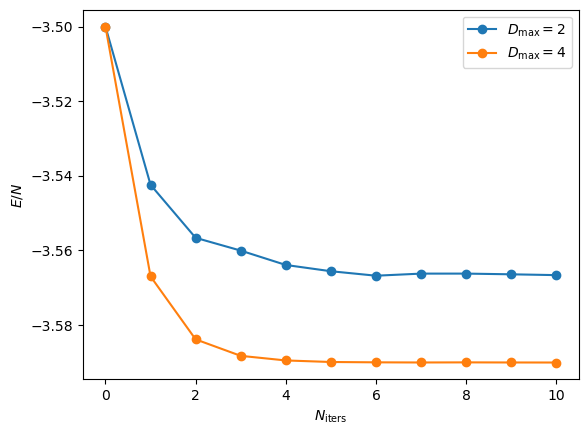

In [5]:
for i, D_max in enumerate(D_maxs):
    plt.plot(np.real_if_close(np.array(Es[i])/(2*tps_parameters["Lx"]*tps_parameters["Ly"])), "o-", label=r"$D_\text{max} = "+str(D_max)+r"$")
plt.legend()
plt.xlabel(r"$N_\text{iters}$")
plt.ylabel(r"$E/N$")
plt.show()

# Finding the optimal time step $\Delta\tau$

In [6]:
import h5py
from src.runs import gs_energy_vs_dtau_TEBD

In [7]:
dtaus = np.logspace(np.log10(0.5), np.log10(0.01), 11)
print(dtaus)

[0.5        0.33812167 0.22865253 0.15462475 0.10456396 0.07071068
 0.04781762 0.03233635 0.02186724 0.01478758 0.01      ]


In [8]:
run_parameters = {
    "tps_params": {
        # Dimensions of the lattice
        "Lx": 4,
        "Ly": 4,
        # Maximum bond dimension
        "D_max": 2,
        "D_max_horizontal": 4,
        "chi_factor": 4,
        # Physical bond dimension
        "d": 2,
        # Options for the YB move
        "yb_options" : { 
            "mode" : "svd",
            "disentangle": True,
            "disentangle_options": {
                "mode": "renyi_approx",
                "renyi_alpha": 0.5,
                "method": "trm",
                "N_iters": 10, # 100
            }
        },
        # Options for the TEBD algorithm
        "tebd_options": {
            "mode" : "iterate_polar",
            "N_iters": 10, # 100
        },
        # Options for variational column optimization
        "perform_variational_column_optimization": False,
        "variational_column_optimization_options": {},
        # debug logging
        "debug_logger_options": {
            "log_algorithm_walltimes": True,
            "log_approximate_column_error_yb": True,
            "log_approximate_column_error_tebd": True,
        }
    },
    "model_params": {
        "g": 3.5,
        "J": 1.0
    },
    "lattice": "honeycomb",
    "dtaus": dtaus,
    # number of TEBD iterations per dtau
    "N_steps": 10 # 50
}
# Maximum bond dimensions
D_maxs = [2, 4]

In [9]:
for D_max in D_maxs:
    print("=========================================================")
    print(f"Computing ground states for D_max = {D_max} ...")
    print("=========================================================")
    start = time.time()
    run_parameters["tps_params"]["D_max"] = D_max
    run_parameters["tps_params"]["D_max_horizontal"] = D_max**2
    run_parameters["output_filename"] = f"output/gs_energy_vs_dtau/D_{D_max}/result_D_{run_parameters["tps_params"]["D_max"]}"
    gs_energy_vs_dtau_TEBD.perform_gs_energy_vs_dtau_run_sequential(**run_parameters)
    end = time.time()
    print(f"-> Took {round(end-start, 3)} seconds in total.")

Computing ground states for D_max = 2 ...
Computing data point for dtau = 0.5 ...
Took 24.076 seconds.
Computing data point for dtau = 0.33812166890312073 ...
Took 23.063 seconds.
Computing data point for dtau = 0.22865252596366317 ...
Took 22.812 seconds.
Computing data point for dtau = 0.15462474735549586 ...
Took 22.718 seconds.
Computing data point for dtau = 0.10456395525912734 ...
Took 22.901 seconds.
Computing data point for dtau = 0.07071067811865475 ...
Took 23.001 seconds.
Computing data point for dtau = 0.04781762498950186 ...
Took 23.436 seconds.
Computing data point for dtau = 0.03233635032886786 ...
Took 23.205 seconds.
Computing data point for dtau = 0.021867241478865564 ...
Took 23.647 seconds.
Computing data point for dtau = 0.014787576366283143 ...
Took 23.982 seconds.
Computing data point for dtau = 0.01 ...
Took 23.499 seconds.
-> Took 256.431 seconds in total.
Computing ground states for D_max = 4 ...
Computing data point for dtau = 0.5 ...
Took 163.27 seconds.
Com

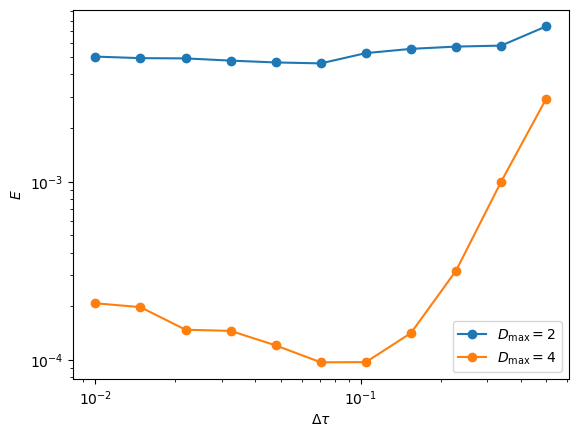

In [11]:
# Numerically exact energy density computed using MPS DMRG
exact_energy = -114.8970536564047933
# Plot error in energy density
for D_max in D_maxs:
    relative_errors = []
    for i, dtau in enumerate(dtaus):
        with h5py.File(f"output/gs_energy_vs_dtau/D_{D_max}/result_D_{D_max}_dtau_{dtau}.h5") as file:
            energy = np.real_if_close(np.average(file["energies"][()][-5:]))
            relative_error = (energy-exact_energy)/(-exact_energy)
            relative_errors.append(relative_error)
    plt.plot(dtaus, relative_errors, "o-", label=r"$D_\text{max} = "+str(D_max)+r"$")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$E$")
plt.xlabel(r"$\Delta\tau$")
plt.legend()
plt.show()